# Importing the libs

In [3]:
import pickle
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Load the data 

In [4]:
# --- Load train ---
with open("../data/train_data.pkl", "rb") as f:
    train = pickle.load(f)

train_images = train["images"]   # (N, H, W, C) probably
train_labels = train["labels"]   # (N,)

train_labels = train["labels"]          # (1080, 1)
y = train_labels.reshape(-1).astype(int)  # (1080,)



print("Train images shape:", train_images.shape)
print("Train labels shape:", train_labels.shape)
print("Label set:", np.unique(train_labels, return_counts=True))

# --- Load test ---
with open("../data/test_data.pkl", "rb") as f:
    test = pickle.load(f)

test_images = test["images"]
print("Test images shape:", test_images.shape)

Train images shape: (1080, 28, 28, 3)
Train labels shape: (1080, 1)
Label set: (array([0, 1, 2, 3, 4], dtype=uint8), array([486, 128, 206, 194,  66]))
Test images shape: (400, 28, 28, 3)


# Data Preprocessing

In [5]:
def preprocess_images(images):
    imgs = images.astype(np.float32)          # (N, 28, 28, 3)

    # to grayscale
    if imgs.ndim == 4 and imgs.shape[-1] > 1:
        imgs = imgs.mean(axis=-1)            # (N, 28, 28)

    # scale to [0,1]
    imgs = imgs / 255.0

    N = imgs.shape[0]
    X = imgs.reshape(N, -1)                  # (N, 784)

    # standardize per feature
    mean = X.mean(axis=0, keepdims=True)
    std = X.std(axis=0, keepdims=True) + 1e-6
    X = (X - mean) / std

    return X, mean, std

X_train, mean, std = preprocess_images(train_images)

def preprocess_test(images, mean, std):
    imgs = images.astype(np.float32)
    if imgs.ndim == 4 and imgs.shape[-1] > 1:
        imgs = imgs.mean(axis=-1)
    imgs = imgs / 255.0
    N = imgs.shape[0]
    X = imgs.reshape(N, -1)
    X = (X - mean) / std
    return X

X_test = preprocess_test(test_images, mean, std)


In [6]:
print(f"X_train shap: {X_train.shape} | X_test shape: {X_test.shape}")

X_train shap: (1080, 784) | X_test shape: (400, 784)


# Manual train/validation split

In [7]:

def stratified_train_val_split(X, y, val_ratio=0.2, seed=42):
    np.random.seed(seed)
    classes = np.unique(y)
    train_idxs = []
    val_idxs = []

    for c in classes:
        idxs = np.where(y == c)[0]
        np.random.shuffle(idxs)
        n_val = int(len(idxs) * val_ratio)
        val_idxs.append(idxs[:n_val])
        train_idxs.append(idxs[n_val:])

    train_idxs = np.concatenate(train_idxs)
    val_idxs = np.concatenate(val_idxs)
    np.random.shuffle(train_idxs)
    np.random.shuffle(val_idxs)

    return train_idxs, val_idxs

X = X_train
y = train_labels.reshape(-1).astype(int)

train_idx, val_idx = stratified_train_val_split(X_train, y, val_ratio=0.2)
X_tr, y_tr = X[train_idx], y[train_idx]
X_val, y_val = X[val_idx], y[val_idx]

print(X_tr.shape, X_val.shape)


(866, 784) (214, 784)


# Model Building

In [8]:
def one_hot(y, num_classes):
    y = y.reshape(-1).astype(int)
    N = y.shape[0]
    Y = np.zeros((N, num_classes), dtype=np.float32)
    Y[np.arange(N), y] = 1.0
    return Y


class SoftmaxClassifier:
    def __init__(self, input_dim, num_classes, reg=1e-3):
        self.W = 0.01 * np.random.randn(input_dim, num_classes).astype(np.float32)
        self.b = np.zeros((1, num_classes), dtype=np.float32)
        self.reg = reg

        # For plotting
        self.train_loss_history = []
        self.val_loss_history = []
        self.train_acc_history = []
        self.val_acc_history = []

        # For early stopping
        self.best_epoch = None
        self.best_val_acc = -np.inf
        self.best_W = None
        self.best_b = None


    def forward(self, X):
        logits = X @ self.W + self.b        # (N, C)
        # numerically stable softmax
        logits_shift = logits - logits.max(axis=1, keepdims=True)
        exp_scores = np.exp(logits_shift)
        probs = exp_scores / exp_scores.sum(axis=1, keepdims=True)
        return probs

    def loss_and_grads(self, X, y):
        N = X.shape[0]
        C = self.W.shape[1]
        probs = self.forward(X)
        Y = one_hot(y, C)

        # Cross-entropy loss + L2 regularization
        core_loss = -np.log(probs[np.arange(N), y] + 1e-12).mean()
        reg_loss = 0.5 * self.reg * (np.sum(self.W * self.W))
        loss = core_loss + reg_loss

        # Gradients
        dlogits = (probs - Y) / N           # (N, C)
        dW = X.T @ dlogits + self.reg * self.W
        db = dlogits.sum(axis=0, keepdims=True)

        return loss, dW, db

    def train(self, X, y, X_val=None, y_val=None,
            lr=1e-2, epochs=200, batch_size=64,
            verbose=True,
            early_stopping=True,
            patience=20,min_delta=1e-4):
        """    Train with mini-batch SGD. early_stopping: if True, stop when val_acc hasn't improved
                            by at least `min_delta` for `patience` epochs.
        """
        N = X.shape[0]

        # reset histories (in case you reuse the object)
        self.train_loss_history = []
        self.val_loss_history = []
        self.train_acc_history = []
        self.val_acc_history = []

        no_improve = 0
        self.best_epoch = None
        self.best_val_acc = -np.inf
        self.best_W = None
        self.best_b = None

        for epoch in range(epochs):
            # --- mini-batch SGD over train set ---
            idxs = np.random.permutation(N)
            epoch_losses = []

            for start in range(0, N, batch_size):
                end = start + batch_size
                batch_idx = idxs[start:end]
                Xb = X[batch_idx]
                yb = y[batch_idx]

                loss, dW, db = self.loss_and_grads(Xb, yb)
                epoch_losses.append(loss)

                self.W -= lr * dW
                self.b -= lr * db

            # --- end of epoch: compute full-train & val metrics ---
            train_loss = np.mean(epoch_losses)
            train_acc = self.accuracy(X, y)

            if X_val is not None and y_val is not None:
                probs_val = self.forward(X_val)
                core_val_loss = -np.log(
                    probs_val[np.arange(len(y_val)), y_val] + 1e-12
                ).mean()
                reg_loss = 0.5 * self.reg * np.sum(self.W * self.W)
                val_loss = core_val_loss + reg_loss
                val_acc = self.accuracy(X_val, y_val)
            else:
                val_loss = np.nan
                val_acc = np.nan

            # store history
            self.train_loss_history.append(train_loss)
            self.val_loss_history.append(val_loss)
            self.train_acc_history.append(train_acc)
            self.val_acc_history.append(val_acc)

            # --- early stopping based on val_acc ---
            if X_val is not None and y_val is not None and early_stopping:
                if val_acc > self.best_val_acc + min_delta:
                    self.best_val_acc = val_acc
                    self.best_epoch = epoch
                    self.best_W = self.W.copy()
                    self.best_b = self.b.copy()
                    no_improve = 0
                else:
                    no_improve += 1
                    if no_improve >= patience:
                        if verbose:
                            print(
                                f"Early stopping at epoch {epoch:03d} "
                                f"(best val_acc={self.best_val_acc:.4f} "
                                f"at epoch {self.best_epoch})"
                            )
                        break

            if verbose and (epoch % 10 == 0 or epoch == epochs - 1):
                print(
                    f"Epoch {epoch:03d} | "
                    f"loss={train_loss:.4f} | "
                    f"train_acc={train_acc:.4f} | "
                    f"val_acc={val_acc:.4f}"
                )

        # restore best weights if we used early stopping
        if X_val is not None and y_val is not None and early_stopping and self.best_W is not None:
            self.W = self.best_W
            self.b = self.best_b


    def predict(self, X):
        probs = self.forward(X)
        return np.argmax(probs, axis=1)

    def accuracy(self, X, y):
        y_pred = self.predict(X)
        return (y_pred == y).mean()


In [9]:
num_classes = 5  # labels 0..4

clf = SoftmaxClassifier(input_dim=X_train.shape[1],
                        num_classes=num_classes,
                        reg=1e-3)

clf.train(
    X_tr, y_tr,
    X_val, y_val,
    lr=0.01,        # smaller
    epochs=200,
    batch_size=64,
    verbose=True
)
print("Final val acc:", clf.accuracy(X_val, y_val))

Epoch 000 | loss=1.4846 | train_acc=0.4423 | val_acc=0.4346
Epoch 010 | loss=1.3111 | train_acc=0.5254 | val_acc=0.5140
Epoch 020 | loss=1.2508 | train_acc=0.5069 | val_acc=0.5000
Early stopping at epoch 025 (best val_acc=0.5280 at epoch 5)
Final val acc: 0.5280373831775701


In [12]:

epochs = np.arange(len(clf.train_loss_history))

hist = pd.DataFrame({
    "epoch": epochs,
    "train_loss": clf.train_loss_history,
    "val_loss": clf.val_loss_history,
    "train_acc": clf.train_acc_history,
    "val_acc": clf.val_acc_history,
})


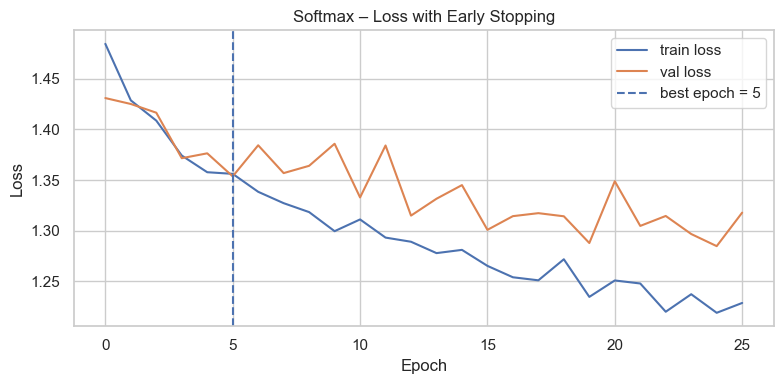

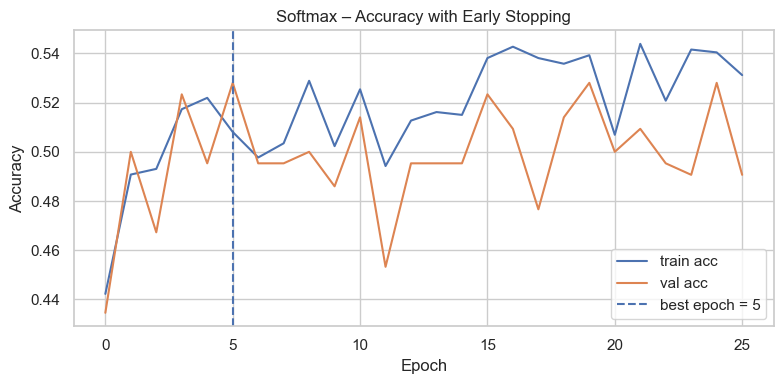

In [13]:
best_epoch = clf.best_epoch

# Loss
plt.figure(figsize=(8, 4))
sns.set_theme(style="whitegrid") # Adds a white background with a gray grid
sns.lineplot(data=hist, x="epoch", y="train_loss", label="train loss")
sns.lineplot(data=hist, x="epoch", y="val_loss", label="val loss")
if best_epoch is not None:
    plt.axvline(best_epoch, linestyle="--", label=f"best epoch = {best_epoch}")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Softmax – Loss with Early Stopping")
plt.legend()
plt.tight_layout()
plt.show()

# Accuracy
plt.figure(figsize=(8, 4))
sns.lineplot(data=hist, x="epoch", y="train_acc", label="train acc")
sns.lineplot(data=hist, x="epoch", y="val_acc", label="val acc")
if best_epoch is not None:
    plt.axvline(best_epoch, linestyle="--", label=f"best epoch = {best_epoch}")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Softmax – Accuracy with Early Stopping")
plt.legend()
plt.tight_layout()
plt.show()


# Model Evaluation

In [14]:
best_epoch = clf.best_epoch   # assuming you stored this in train()

clf_full = SoftmaxClassifier(
    input_dim=X_train.shape[1],
    num_classes=5,
    reg=clf.reg
)

# Train on ALL train data for exactly best_epoch+1 epochs
clf_full.train(
    X_train, y,
    X_val=None, y_val=None,
    lr=0.01,
    epochs=best_epoch + 1,
    batch_size=64,
    verbose=False
)

y_test_pred = clf_full.predict(X_test)

In [ ]:
ids = np.arange(1, len(y_test_pred) + 1)
sub = pd.DataFrame({"ID": ids, "Label": y_test_pred})
sub.to_csv("beating_baseline.csv", index=False)